<a href="https://colab.research.google.com/github/magladko/NAI/blob/master/mpp4/mpp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#K-means – NAI mini-project
###*Kornel Gładkowski @s22411*

##Import libs, mount drives

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# from google.colab import drive
# drive.mount('/content/drive')

# !git clone https://github.com/magladko/NAI.git

##Util functions

In [ ]:
def calculate_centroid(df: pd.DataFrame, cluster_id: int):
    length = len(df.loc[df["cluster"] == cluster_id])
    if length == 0:
        return None
    res = df.loc[df["cluster"] == cluster_id].iloc[:, 1:-k-1].sum(axis=0)/length
    return res

def get_dist_sq(points: pd.DataFrame, centroid: pd.Series):
    res = (points.subtract(centroid)**2)
    res["sum"] = res.sum(axis=1)
    return res["sum"]

##Set user input

- raw path iris: https://raw.githubusercontent.com/magladko/NAI/master/mpp4/data/iris_all.csv

- raw path dane_testowe.csv: https://raw.githubusercontent.com/magladko/NAI/master/mpp4/data/dane_testowe.csv

In [ ]:
#@title Enter number of class { run: "auto", display-mode: "form" }
k = 2 #@param {type:"slider", min:1, max:10, step:1}
DATA_PATH = "https://raw.githubusercontent.com/magladko/NAI/master/mpp4/data/dane_testowe.csv" #@param {type:"string"}


##Initialize data
Read data & assign random cluster to observation

In [ ]:
base_df = pd.read_csv(DATA_PATH) #  + "iris_all.csv"
train_df = base_df.iloc[:, :-1]

train_df['cluster'] = np.random.randint(1, k+1, train_df.shape[0])

# assign random values until all possibles values have assigned observation
while not np.all(np.isin([i for i in range(1, k+1)] ,train_df['cluster'].unique())):
    train_df['cluster'] = np.random.randint(1, k+1, train_df.shape[0])

# initialize distances from clusters
for i in range(1, k+1):
    train_df[i] = np.NaN

# initialize centroids of clusters
centroids = pd.DataFrame(columns=train_df.iloc[:, 1: -k-1].columns)

for i in range(1, k+1):
    temp = calculate_centroid(train_df, i)
    centroids.loc[i] = temp if temp is not None else pd.Series([np.NaN]*k)

print("cluster centroids:")
print(centroids, end='\n\n')
train_df

cluster centroids:
          x         y
1 -3.500000 -0.500000
2  1.333333  0.666667



,nr,x,y,cluster,1,2
0,1,-5,0,2,NaN,NaN
1,2,-4,1,1,NaN,NaN
2,3,-3,-2,1,NaN,NaN
3,4,4,0,2,NaN,NaN
4,5,5,2,2,NaN,NaN


###Initial state plot

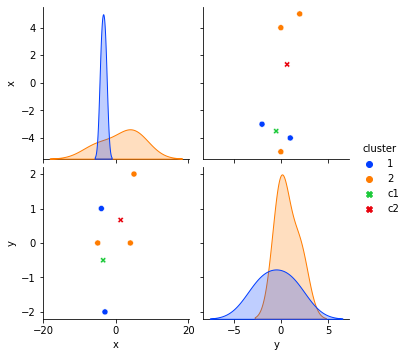

In [ ]:
# adjust centroids DFs for plotting
centroids2 = centroids.reset_index()
centroids2.rename(columns={"index" : "cluster"}, inplace=True)
centroids2["cluster"] = centroids2["cluster"].apply(lambda cluster: f"c{cluster}")

# plot data with centroids
sns.pairplot(train_df.iloc[:, 1:-k].sort_values("cluster").append(centroids2, ignore_index=True), 
             hue='cluster', 
             markers=(["o"]*k)+(["X"]*k),
             palette=sns.color_palette("bright", k+k))

##Adjust clusters' centroids until nothing changes

In [ ]:
distances_df = pd.DataFrame(data=np.NaN, index=list(range(1, k+1)), columns=['distance_sq','cluster_size'])
iterations = 0
any_distance_changed = True
while any_distance_changed:
    any_distance_changed = False
    
    for i in range(1, k+1):   
        temp = calculate_centroid(train_df, i)
        if temp is not None:
            centroids.loc[i] = temp

    for i in range(1, k+1):
        dist = get_dist_sq(train_df.iloc[:, 1:-k-1], centroids.loc[i])
        dist_with_cluster = train_df.join(dist).loc[:, ['cluster', 'sum']]

        distances_df.loc[i]['distance_sq'] = dist_with_cluster[dist_with_cluster['cluster']==i]['sum'].sum()
        distances_df.loc[i]['cluster_size'] = len(dist_with_cluster[dist_with_cluster['cluster']==i])

        if not train_df[i].equals(dist):
            # print(dist)
            train_df[i] = dist
            any_distance_changed = True
    
    train_df["cluster"] = train_df.iloc[:, -k:].idxmin(axis=1)
    iterations += 1
    print("iteration:", iterations)
    print(distances_df, end='\n\n')

print()
print("total iterations:", iterations)
print("centroids:")
print(centroids)
train_df

iteration: 1
   distance_sq  cluster_size
1     5.000000           2.0
2    63.333333           3.0

iteration: 2
   distance_sq  cluster_size
1     6.666667           3.0
2     2.500000           2.0

iteration: 3
   distance_sq  cluster_size
1     6.666667           3.0
2     2.500000           2.0


total iterations: 3
centroids:
     x         y
1 -4.0 -0.333333
2  4.5  1.000000


,nr,x,y,cluster,1,2
0,1,-5,0,1,1.111111,91.25
1,2,-4,1,1,1.777778,72.25
2,3,-3,-2,1,3.777778,65.25
3,4,4,0,2,64.111111,1.25
4,5,5,2,2,86.444444,1.25


###Final state plot

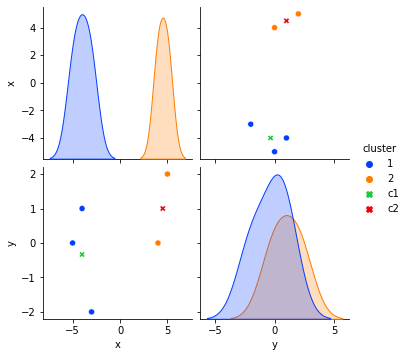

In [ ]:
# adjust centroids DFs for plotting
centroids2 = centroids.reset_index()
centroids2.rename(columns={"index" : "cluster"}, inplace=True)
centroids2["cluster"] = centroids2["cluster"].apply(lambda cluster: f"c{cluster}")

not_empty_cluster_count = len(train_df["cluster"].unique())

# plot data with centroids
sns.pairplot(train_df.iloc[:, 1:-k].append(centroids2, ignore_index=True), 
             hue='cluster',
             markers=["o"]*not_empty_cluster_count+(["X"]*k),
             palette=sns.color_palette("bright", not_empty_cluster_count+k))

##Percentage of classes in clusters

In [ ]:
answer_df = base_df.iloc[:, [0, -1]]
answer_df = pd.merge(answer_df, train_df.iloc[:, [0, -k-1]], on=answer_df.columns[0])

percent_df = answer_df.groupby(['cluster', answer_df.columns[1]]).count().groupby(level=0).transform(lambda x: (x / x.sum() * 100).round(2))
percent_df.rename(columns={"nr": "%"}, inplace=True)
percent_df

,,%
cluster,class,
1,versicolor,100.0
2,setosa,100.0
